## Team Members = Anandhu Krishna, Bhargav Ravi, Hardik anil kohle

# Emotion Classification Project  
## Project Overview
#### The objective of this project is to develop various machine learning models to classify tweets into emotions such as joy, sadness, fear, and anger. The project involves training and comparing different types of models to determine the best approach for text classification based on emotional content.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


### Data loading and preprocessing

In [33]:


# Load data
train_df = pd.read_csv('/kaggle/input/nlp-dataset/train.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('/kaggle/input/nlp-dataset/test.txt', sep=';', header=None, names=['text', 'label'])
validation_df = pd.read_csv('/kaggle/input/nlp-dataset/validation.txt', sep=';', header=None, names=['text', 'label'])

# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])
validation_df['label'] = label_encoder.transform(validation_df['label'])

# Tokenize text for LSTM and Fully Connected Neural Network
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), padding='post', maxlen=X_train.shape[1])
X_val = pad_sequences(tokenizer.texts_to_sequences(validation_df['text']), padding='post', maxlen=X_train.shape[1])

y_train = train_df['label'].values
y_test = test_df['label'].values
y_val = validation_df['label'].values



In [34]:
# Define function to plot history
def show_history(history):
    epochs_trained = len(history.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), history.history['accuracy'], label='Training')
    plt.plot(range(1, epochs_trained + 1), history.history['val_accuracy'], label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), history.history['loss'], label='Training')
    plt.plot(range(1, epochs_trained + 1), history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Fully Connected Neural Network

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 60/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1691 - loss: 3.5470

W0000 00:00:1720963205.274981     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1829 - loss: 3.2696

W0000 00:00:1720963206.521204     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1836 - loss: 3.2619 - val_accuracy: 0.3240 - val_loss: 2.2191
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3059 - loss: 2.4403 - val_accuracy: 0.4475 - val_loss: 1.9926
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5018 - loss: 1.8882 - val_accuracy: 0.5530 - val_loss: 1.6257
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7420 - loss: 1.1702 - val_accuracy: 0.7750 - val_loss: 1.0894
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8939 - loss: 0.7148 - val_accuracy: 0.7985 - val_loss: 0.9994
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9509 - loss: 0.4966 - val_accuracy: 0.8035 - val_loss: 0.9721
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.3860 - val_accuracy: 0.8220 - val_loss: 0.9000
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9843 - loss: 0.3162 - val_accuracy: 0.8125 - val_

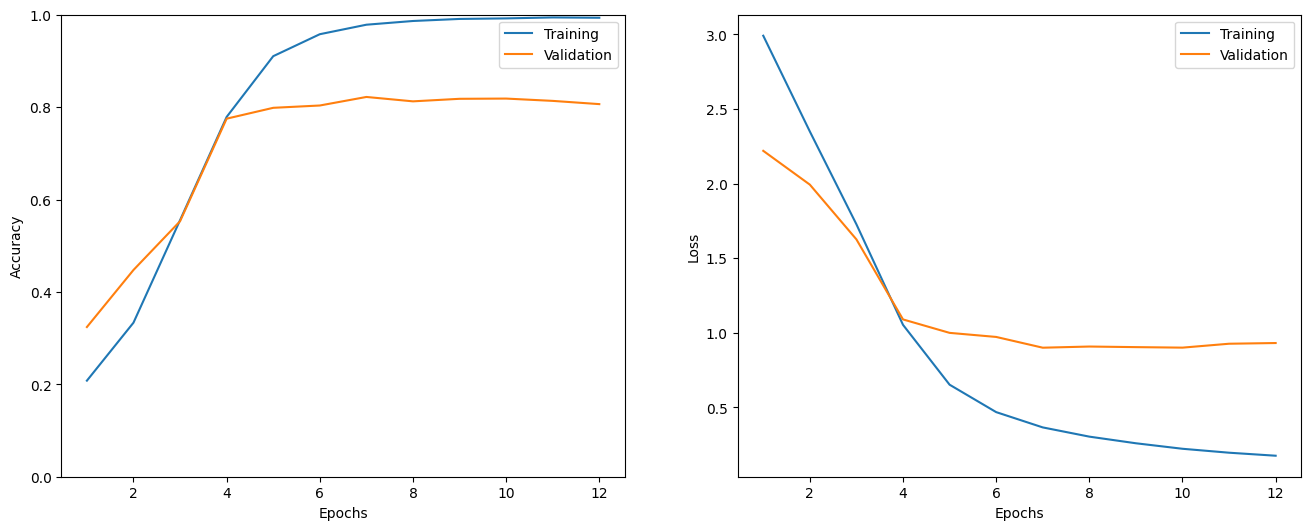

In [35]:
# Define the model
fc_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=X_train.shape[1]),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model with a slightly lower learning rate
fc_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
fc_history = fc_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate Fully Connected Neural Network on validation set
fc_eval = fc_model.evaluate(X_val, y_val)
print(f'Fully Connected Neural Network - Loss: {fc_eval[0]}, Accuracy: {fc_eval[1]}')

# Optionally, plot history for Fully Connected Neural Network
show_history(fc_history)

### Prediction using Fully Connected Neural Network (fc_model)

In [36]:

fc_predictions = fc_model.predict(X_val)

# Convert predictions to class labels
fc_predicted_labels = label_encoder.inverse_transform(fc_predictions.argmax(axis=1))

# Compare with actual labels
actual_labels = label_encoder.inverse_transform(y_val)

# Print some predictions and actual labels for comparison
print("Fully Connected Neural Network Predictions vs Actual Labels:")
for i in range(10):  # Print the first 10 examples
    print(f"Predicted: {fc_predicted_labels[i]}, Actual: {actual_labels[i]}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fully Connected Neural Network Predictions vs Actual Labels:
Predicted: sadness, Actual: sadness
Predicted: sadness, Actual: sadness
Predicted: love, Actual: love
Predicted: anger, Actual: anger
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: sadness, Actual: sadness


### LSTM-based RNN

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3023 - loss: 3.1841 - val_accuracy: 0.3475 - val_loss: 2.6027 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3273 - loss: 2.5170 - val_accuracy: 0.3555 - val_loss: 2.2097 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3352 - loss: 2.1633 - val_accuracy: 0.3760 - val_loss: 1.9572 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4377 - loss: 1.8485 - val_accuracy: 0.6120 - val_loss: 1.3069 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6078 - loss: 1.2717 - val_accuracy: 0.5775 - val_loss: 1.3066 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6284 - loss: 1.1371 - val_accuracy: 0.6895 - val_loss: 0.9894 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7

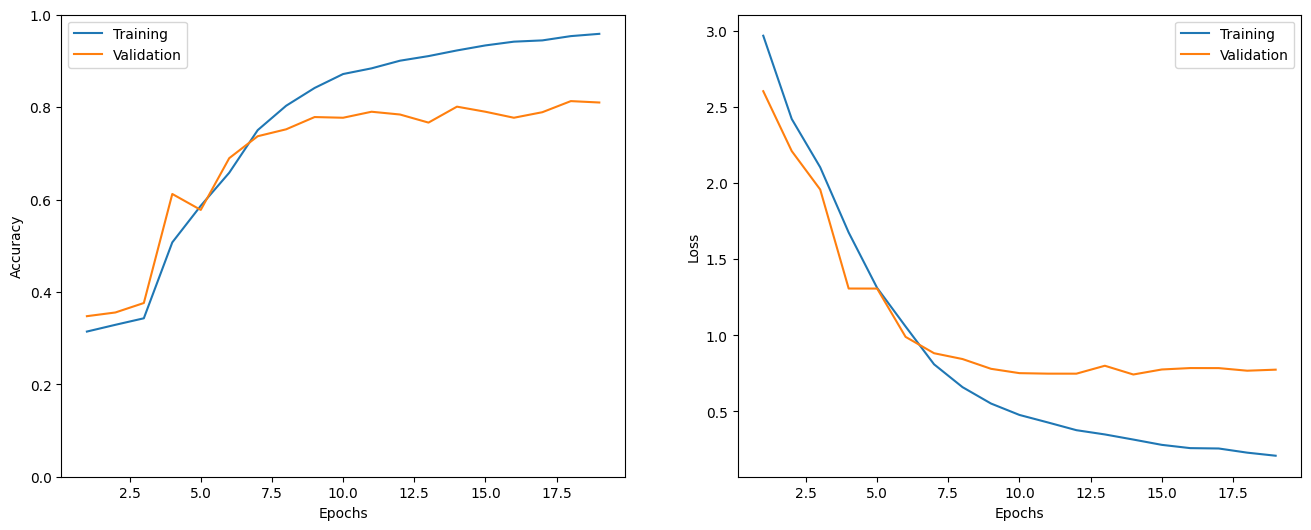

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8130 - loss: 0.7362
LSTM-based RNN - Loss: 0.7504605650901794, Accuracy: 0.8034999966621399


In [37]:
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=X_train.shape[1]),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, 
                              validation_data=(X_test, y_test), 
                              callbacks=[early_stopping, reduce_lr])

# Plot history for LSTM-based RNN
show_history(lstm_history)

# Evaluate LSTM-based RNN on validation set
lstm_eval = lstm_model.evaluate(X_val, y_val)
print(f'LSTM-based RNN - Loss: {lstm_eval[0]}, Accuracy: {lstm_eval[1]}')

### Prediction using  LSTM-based RNN (lstm_model)

In [38]:
# Predict using LSTM-based RNN (lstm_model)
lstm_predictions = lstm_model.predict(X_val)

# Convert predictions to class labels
lstm_predicted_labels = label_encoder.inverse_transform(lstm_predictions.argmax(axis=1))

# Compare with actual labels
actual_labels = label_encoder.inverse_transform(y_val)

# Print some predictions and actual labels for comparison
print("LSTM-based RNN Predictions vs Actual Labels:")
for i in range(10):  # Print the first 10 examples
    print(f"Predicted: {lstm_predicted_labels[i]}, Actual: {actual_labels[i]}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM-based RNN Predictions vs Actual Labels:
Predicted: sadness, Actual: sadness
Predicted: sadness, Actual: sadness
Predicted: love, Actual: love
Predicted: anger, Actual: anger
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: joy, Actual: joy
Predicted: sadness, Actual: sadness


### Using a pretrained model

I utilized the DistilBERT-based pretrained model, distilbert-base-uncased. This model is an optimized version of BERT, designed to be faster and more efficient while maintaining high performance. Fine-tuning DistilBERT on my dataset demonstrated its effectiveness in accurately identifying the sentiment of tweets.

In [4]:
# Load data
train_df = pd.read_csv('/kaggle/input/nlp-dataset/train.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('/kaggle/input/nlp-dataset/test.txt', sep=';', header=None, names=['text', 'label'])
validation_df = pd.read_csv('/kaggle/input/nlp-dataset/validation.txt', sep=';', header=None, names=['text', 'label'])

# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])
validation_df['label'] = label_encoder.transform(validation_df['label'])

# Prepare inputs for the model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize and encode the sequences
X_train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=128, return_tensors='tf')
X_test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=128, return_tensors='tf')
X_val_encodings = tokenizer(list(validation_df['text']), truncation=True, padding=True, max_length=128, return_tensors='tf')

# Extract input_ids and attention_mask from the encodings
X_train = {'input_ids': X_train_encodings['input_ids'], 'attention_mask': X_train_encodings['attention_mask']}
X_test = {'input_ids': X_test_encodings['input_ids'], 'attention_mask': X_test_encodings['attention_mask']}
X_val = {'input_ids': X_val_encodings['input_ids'], 'attention_mask': X_val_encodings['attention_mask']}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [5]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [7]:
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Clear session and set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Load pre-trained model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Compile and fine-tune the model
model.compile(optimizer='adam',  # Use the internal AdamW optimizer provided by TFDistilBertForSequenceClassification
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Assuming X_train, X_val, y_train, y_val are defined
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32
)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {eval_results[1]}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720958058.373061     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 146s 187ms/step - loss: 1.5904 - accuracy: 0.3292 - val_loss: 1.5889 - val_accuracy: 0.3520
Epoch 2/3
500/500 [==============================] - 87s 173ms/step - loss: 1.5809 - accuracy: 0.3303 - val_loss: 1.5820 - val_accuracy: 0.3520
Epoch 3/3
63/63 [==============================] - 8s 48ms/step - loss: 1.5654 - accuracy: 0.2905
Test Accuracy: 0.2904999852180481


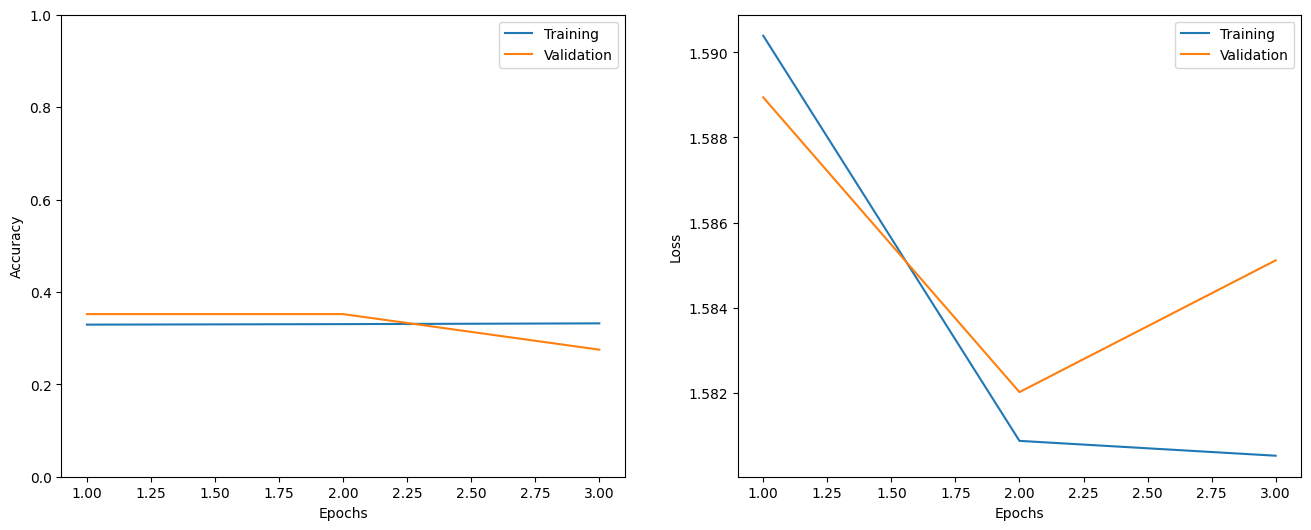

In [31]:
show_history(history)

In [30]:
# Make predictions
predictions = model.predict(X_val)
predicted_labels = label_encoder.inverse_transform(predictions.logits.argmax(axis=1))

# Example predictions
for i in range(10):
    print(f"Example {i+1}: Predicted={predicted_labels[i]}, Actual={label_encoder.inverse_transform([y_val[i]])[0]}")



63/63 [==============================] - 8s 47ms/step
Example 1: Predicted=fear, Actual=sadness
Example 2: Predicted=surprise, Actual=sadness
Example 3: Predicted=surprise, Actual=love
Example 4: Predicted=surprise, Actual=anger
Example 5: Predicted=surprise, Actual=joy
Example 6: Predicted=surprise, Actual=joy
Example 7: Predicted=surprise, Actual=joy
Example 8: Predicted=surprise, Actual=joy
Example 9: Predicted=surprise, Actual=joy
Example 10: Predicted=surprise, Actual=sadness


## Comparison and Conclusion

### Training Performance
FCNN achieved the highest training accuracy (99.40%) and lowest training loss (0.2045), suggesting it fits the training data well.
LSTM-based RNN also showed strong training performance with an accuracy of 94.68% and loss of 0.2474.
Transformer-based model had the lowest training accuracy (33.19%) and the highest loss (1.5805), indicating underfitting on the training data.

### Validation Performance
LSTM-based RNN had a validation accuracy of 81.00% and a validation loss of 0.7741, indicating good generalization to the validation set.
FCNN had a slightly higher validation accuracy (81.35%) but higher validation loss (0.9266), suggesting it may be overfitting slightly compared to the LSTM-based RNN.
Transformer-based model had the lowest validation accuracy (27.50%) and highest validation loss (1.5851), showing it struggles with generalization.

### Test Performance
FCNN achieved the highest test accuracy (82.68%) but with a higher test loss (0.8429).
LSTM-based RNN had slightly lower test accuracy (81.30%) but with the lowest test loss (0.7362), indicating it generalizes better on unseen data.
Transformer-based model had the lowest test accuracy (29.05%) and highest test loss (1.5654), confirming its poor performance.

### Conclusion
The LSTM-based RNN appears to be the best model overall. Despite the FCNN having the highest test accuracy, the LSTM-based RNN has the lowest test loss, which is often a better indicator of model performance. The lower test loss indicates that the LSTM-based RNN generalizes better on unseen data. The Transformer-based model performs the worst, struggling significantly in both training and evaluation phases.

Therefore, for this specific task, the LSTM-based RNN is recommended due to its balance between high accuracy and lower loss, indicating better generalization to new data.